# Gaussian Process

高斯过程假设 $f(x)$ （而非 $x$ 本身）满足多项高斯分布。

$$
p(f|X) = \mathcal{N} (f | \mu, K)
$$

In [295]:
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install scikit-learn
!pip install pyDOE
!pip install rich

     |████████████████████████████████| 212 kB 645 kB/s 
  Using cached commonmark-0.9.1-py2.py3-none-any.whl (51 kB)
  Using cached colorama-0.4.4-py2.py3-none-any.whl (16 kB)


In [1]:
%load_ext autoreload
%autoreload 2


In [5]:
# import all packages and set plots to be embedded inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.linalg import cho_solve
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import rich
from plotutil import PlotLayout

%matplotlib inline


## Sampling

https://blog.dominodatalab.com/fitting-gaussian-process-models-python

`kernel`:
$$
k(x_1, x_2) = \theta_1 \exp (- \frac{\theta_2}{2} (x_1 - x_2) ^ 2)
$$

`conditional`:
$$
\begin{aligned}
p(f_* | X_*, X, f) & = \mathcal{N}(f_* | \mu_*, \Sigma_*) \\

\mu_*    & = \mu(X_*) + K_*^{\mathrm{T}} K^{-1} (f - \mu(X)) \\
\Sigma_* & = K_{**}   K_*^{\mathrm{T}} K_*^{-1} K_{*} \\

where: & K = N \times N, K_* = N \times N_*, K_{**} = N_* \times N_*
\end{aligned}
$$

条件概率公式来自 `MLAPP 15.6~15.8`。其中，$ X_* $ 是新数据，$X$ 是老数据, $ f $ 是老数据的观察值，$ p(f*) $ 是新数据的观察值的分布。数据间的相似度通过 kernel 计算。

https://stats.stackexchange.com/questions/222238/why-is-the-mean-function-in-gaussian-process-uninteresting

一般假设均值为 0，因为核心是在协方差矩阵上。训练集只是整体的一部分，远离训练集的部分回归到 0 并没有问题。至于训练集区域，更关注的是条件概率，均值为 0 只是某种先验。

- The zero mean GP, which always converges to 0 away from the training set, is safer than a model, which will happily shoot out insanely large predictions as soon as you get away from the training data.

- The predictive mean is the mean of the Gaussian Process predictions, obtained by conditioning the GP on the training points. Even if the mean of the GP prior is zero, the predictive mean is not zero at all, and depending on the kernel and on the number of training points, it can be a very flexible model, able to learn extremely complex patterns.


1.0


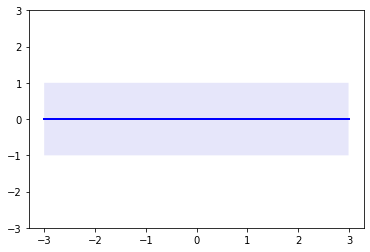

In [8]:
# return shape: len(x1) x len(x2)
def kernel(x1, x2, params):
    return params[0] * np.exp(-0.5 * params[1] * np.subtract.outer(x1, x2)**2)

def conditional(x_new, x, y, params):   
    Kss = kernel(x_new, x_new, params)
    Ks = kernel(x, x_new, params)
    K = kernel(x, x, params)
    mu = Ks.T.dot(np.linalg.inv(K)).dot(y)
    sigma = Kss - Ks.T.dot(np.linalg.inv(K)).dot(Ks)
    return mu.squeeze(), sigma.squeeze()

def predict(x_new, x, kernel, params, x_sigma, y):
    k = [kernel(x_new, ele, params) for ele in x]
    Sinv = np.linalg.inv(x_sigma)
    y_pred = np.dot(k, Sinv).dot(y)
    y_sigma = kernel(x_new, x_new, params) - np.dot(k, Sinv).dot(k)
    return y_pred, y_sigma
    
θ = [1, 10]
σ_0 = kernel(0, 0, θ)
print(σ_0)
xpts = np.arange(-3, 3, step=0.01)
plt.fill_between(xpts.flatten(), - np.sqrt(σ_0), np.sqrt(σ_0), facecolor='lavender')
plt.plot(xpts, np.zeros_like(xpts), 'b-', lw=2)
plt.ylim(-3, 3)
pass

allocating 2 rows x 2 cols for 4 subplots.


>>> idx: 0, x: [1.], y: [-1.0541], σ: 
[[1.]]

>>> idx: 1, x: [1.  0.4], y: [-1.0541 -1.7014], σ: 
[[1.     0.1653]
 [0.1653 1.    ]]

>>> idx: 2, x: [ 1.   0.4 -0.2], y: [-1.0541 -1.7014  0.517 ], σ: 
[[1.0000e+00 1.6530e-01 7.4659e-04]
 [1.6530e-01 1.0000e+00 1.6530e-01]
 [7.4659e-04 1.6530e-01 1.0000e+00]]

>>> idx: 3, x: [ 1.   0.4 -0.2  1.8], y: [-1.0541 -1.7014  0.517  -0.2755], σ: 
[[1.0000e+00 1.6530e-01 7.4659e-04 4.0762e-02]
 [1.6530e-01 1.0000e+00 1.6530e-01 5.5452e-05]
 [7.4659e-04 1.6530e-01 1.0000e+00 2.0612e-09]
 [4.0762e-02 5.5452e-05 2.0612e-09 1.0000e+00]]

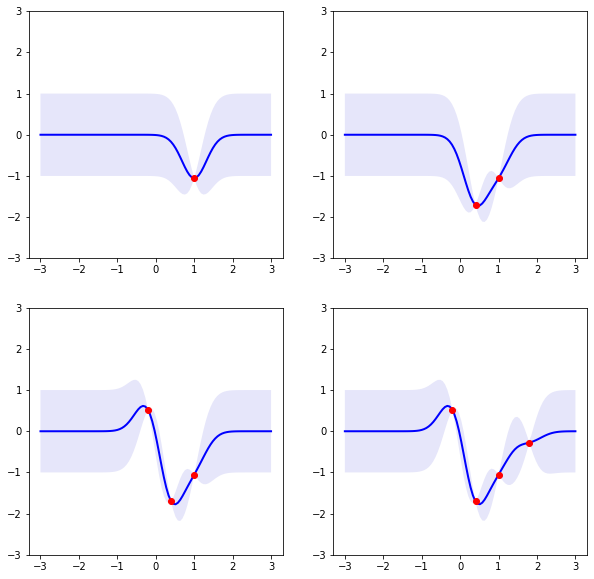

In [9]:
x = []
y = []
np.set_printoptions(precision=4)

x_to_add = [1.0, 0.4, -0.2, 1.8]
layout = PlotLayout(plt, total_num=len(x_to_add), num_per_row=2)
layout.prepare()

for idx, ele in enumerate(x_to_add): 
    x_new = [ele]
    if len(x) == 0:
        y_new = np.random.normal(scale=σ_0)
    else:
        mu, s = conditional(x_new, x, y, θ)
        y_new = np.random.normal(mu, s)

    x.extend(x_new)
    y.append(y_new)
    σ = kernel(x, x, θ)
    rich.print(f">>> idx: {idx}, x: {np.array(x)}, y: {np.array(y)}, σ: \n{np.array(σ)}")

    x_pred = np.linspace(-3, 3, 100)
    predictions = [predict(i, x, kernel, θ, σ, y) for i in x_pred]
    y_pred, y_sigmas = np.transpose(predictions)

    ax = layout.subplot(idx)
    ax.fill_between(x_pred.flatten(), y_pred-np.sqrt(y_sigmas), y_pred+np.sqrt(y_sigmas), facecolor='lavender')
    ax.plot(x_pred, y_pred, 'b-', lw=2)
    ax.plot(x, y, "ro")
    plt.ylim(-3, 3)


(-3.0, 3.0)

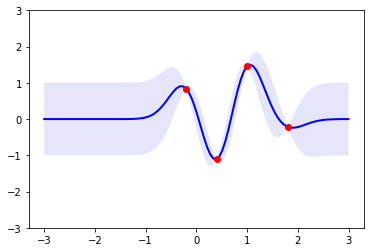

In [10]:
x = [1.]
y = [np.random.normal(scale=σ_0)]

x_more = [0.4, -0.2, 1.8]
mu, s = conditional(x_more, x, y, θ)
y_more = np.random.multivariate_normal(mu, s)

x += x_more
y += y_more.tolist()
σ_new = kernel(x, x, θ)
predictions = [predict(i, x, kernel, θ, σ_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)
plt.fill_between(x_pred.flatten(), y_pred-np.sqrt(sigmas), y_pred+np.sqrt(sigmas),
                facecolor='lavender')
plt.plot(x_pred.flatten(), y_pred.flatten(), 'b-', lw=2)
plt.plot(x, y, "ro")
plt.ylim(-3, 3)

## Optimization

https://towardsdatascience.com/implement-a-gaussian-process-from-scratch-2a074a470bce
https://github.com/ShuaiGuo16/Gaussian-Process

### Correlation length

Text(0, 0.5, '$e^{-\\theta (x_i-x_j)^2}$')

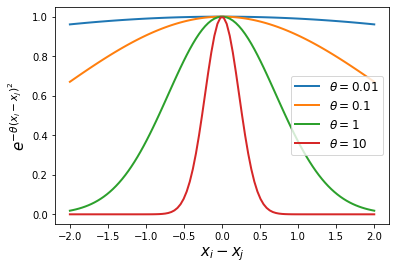

In [92]:
# Define parameter range and theta values
shift = np.linspace(-2, 2, 100)
thetas = np.array([0.01, 0.1, 1, 10])

# Calculate correlation under various theta values
corrs = [np.exp(-theta*shift**2) for theta in thetas]

# Visualize results
fig, ax = plt.subplots()

# Define labels
labels = [r'$\theta=0.01$', r'$\theta=0.1$', r'$\theta=1$', r'$\theta=10$']

for i in range(thetas.shape[0]):
    ax.plot(shift, corrs[i], label=labels[i], lw=2)
ax.legend(fontsize=12)
ax.set_xlabel(r'$x_i-x_j$', fontsize=15)
ax.set_ylabel(r'$e^{-\theta (x_i-x_j)^2}$', fontsize=15)


### Gaussian Process class

In [11]:
class GaussianProcess:
    """A Gaussian Process class that trains and exploits 
    a Gaussian Process model"""

    def __init__(self, n_restarts, optimizer):
        """Initialize a Gaussian Process model

        Input
        ------
        n_restarts: number of restarts of the local optimizer
        optimizer: algorithm of local optimization"""

        self.n_restarts = n_restarts
        self.optimizer = optimizer

    @staticmethod
    def Corr(X1, X2, theta):
        """Construct the correlation matrix between X1 and X2

        Input
        -----
        X1, X2: 2D arrays, shape (n_samples, n_features)
        theta: array, correlation legnths for different dimensions

        Output
        ------
        K: the correlation matrix
        """
        K = np.zeros((X1.shape[0], X2.shape[0]))
        for i in range(X1.shape[0]):
            K[i, :] = np.exp(-np.sum(theta*(X1[i, :]-X2)**2, axis=1))

        return K

    def Neglikelihood(self, theta):
        """Negative likelihood function

        Input
        -----
        theta: array, correlation legnths for different dimensions

        Output
        ------
        LnLike: likelihood value"""

        theta = 10**theta    # Correlation length
        n = self.X.shape[0]  # Number of training instances
        one = np.ones((n, 1))      # Vector of ones

        # Construct correlation matrix
        K = GP.Corr(self.X, self.X, theta) + np.eye(n)*1e-10
        inv_K = np.linalg.inv(K)   # Inverse of correlation matrix

        # Mean estimation
        mu = (one.T @ inv_K @ self.y)/ (one.T @ inv_K @ one)

        # Variance estimation
        SigmaSqr = (self.y-mu*one).T @ inv_K @ (self.y-mu*one) / n

        # Compute log-likelihood
        LnDetK = np.log(np.linalg.det(K))
        LnLike = -(n/2)*np.log(SigmaSqr) - 0.5*LnDetK

        # Update attributes
        self.K, self.inv_K, self.mu, self.SigmaSqr = K, inv_K, mu, SigmaSqr

        return -LnLike.flatten()

    def fit(self, X, y):
        """GP model training

        Input
        -----
        X: 2D array of shape (n_samples, n_features)
        y: 2D array of shape (n_samples, 1)
        """

        self.X, self.y = X, y
        lb, ub = -1, 2

        # Generate random starting points (Latin Hypercube)
        lhd = lhs(self.X.shape[1], samples=self.n_restarts)

        # Scale random samples to the given bounds
        initial_points = (ub-lb)*lhd + lb

        # Create A Bounds instance for optimization
        bnds = Bounds(lb*np.ones(X.shape[1]), ub*np.ones(X.shape[1]))

        # Run local optimizer on all points
        opt_para = np.zeros((self.n_restarts, self.X.shape[1]))
        opt_func = np.zeros((self.n_restarts, 1))
        for i in range(self.n_restarts):
            res = minimize(self.Neglikelihood, initial_points[i, :], method=self.optimizer,
                        bounds=bnds)
            opt_para[i, :] = res.x
            opt_func[i, :] = res.fun

        # Locate the optimum results
        self.theta = opt_para[np.argmin(opt_func)]

        # Update attributes
        self.NegLnlike = self.Neglikelihood(self.theta)

    def predict(self, X_test):
        """GP model predicting

        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)

        Output
        ------
        f: GP predictions
        SSqr: Prediction variances"""

        n = self.X.shape[0]
        one = np.ones((n, 1))

        # Construct correlation matrix between test and train data
        k = GP.Corr(self.X, X_test, 10**self.theta)

        # Mean prediction
        f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)

        # Variance prediction
        SSqr = self.SigmaSqr*(1 - np.diag(k.T @ self.inv_K @ k))

        return f.flatten(), SSqr.flatten()

    def score(self, X_test, y_test):
        """Calculate root mean squared error

        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        y_test: test labels, array of shape (n_samples, )

        Output
        ------
        RMSE: the root mean square error"""

        y_pred, SSqr = self.predict(X_test)
        RMSE = np.sqrt(np.mean((y_pred-y_test)**2))

        return RMSE


### 1D Test Case

(-10.0, 20.0)

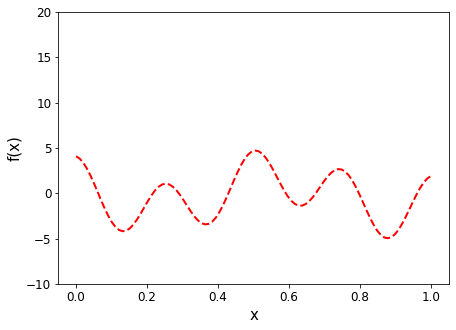

In [13]:
def test1d(X):
    """1D Test Function"""

    # y = (6 * X - 2) ** 2 * np.sin(2 * 3.14 * X -4) + 2
    y = 2 * np.cos(3 * 3.14 * X + 1) + 3 * np.cos(8 * 3.14 * X)

    return y


# Display the function to be approximated
fig, ax = plt.subplots(figsize=(7, 5))

X = np.linspace(0.0, 1, 100).reshape(-1, 1)
y = test1d(X)

ax.plot(X, y, 'r--', lw=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10, 20])


allocating 2 rows x 3 cols for 6 subplots.


/Users/admin/opt/miniconda3/envs/mlvis/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/Users/admin/opt/miniconda3/envs/mlvis/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/admin/opt/miniconda3/envs/mlvis/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/admin/opt/miniconda3/envs/mlvis/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in log
/Users/admin/opt/miniconda3/envs/mlvis/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in log


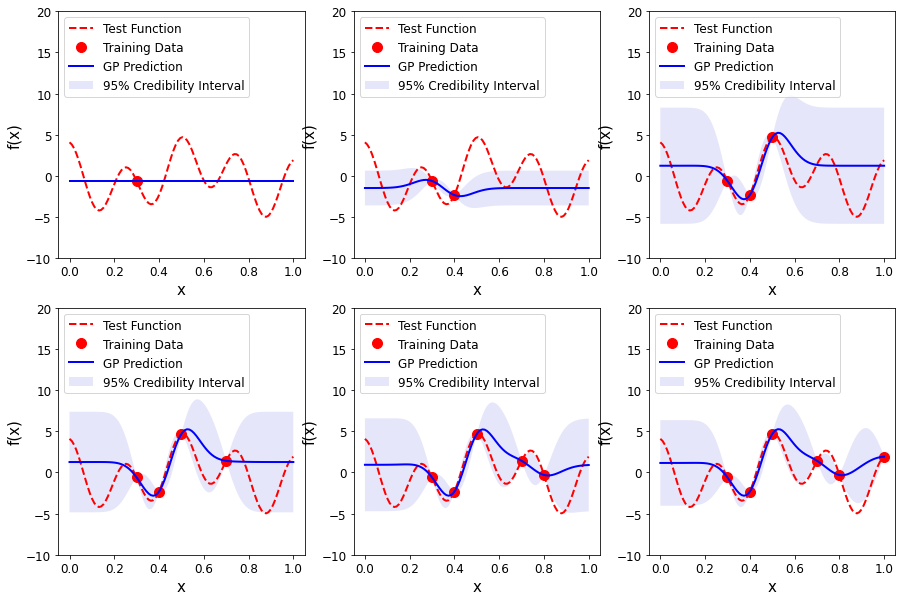

In [15]:
from plotutil import PlotLayout

# Training data
X_train = np.array([0.3, 0.4, 0.5, 0.7, 0.8, 1.0]).reshape(-1, 1)
y_train = test1d(X_train)

# Testing data
X_test = np.linspace(0.0, 1.0, 100).reshape(-1, 1)
y_test = test1d(X_test)


train_points_num = len(X_train)
layout = PlotLayout(plt, train_points_num, num_per_row=3)
layout.prepare()

for i in range(1, train_points_num+1):
    ax = layout.subplot(i-1)
    # GP model training
    GP = GaussianProcess(n_restarts=10, optimizer='L-BFGS-B')
    GP.fit(X_train[:i], y_train[:i])

    # GP model predicting
    y_pred, y_pred_SSqr = GP.predict(X_test)

    ax.plot(X_test, y_test, 'r--', linewidth=2, label='Test Function')
    ax.plot(X_train[:i], y_train[:i], 'ro', markerfacecolor='r',
            markersize=10, label='Training Data')
    ax.plot(X_test, y_pred, 'b-', lw=2, label='GP Prediction')
    ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr),
                    y_pred+1.96*np.sqrt(y_pred_SSqr),
                    facecolor='lavender', label='95% Credibility Interval')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('f(x)', fontsize=15)
    ax.set_ylim([-10, 20])
    ax.legend(loc="upper left", prop={'size': 12})


### 2D Test Case

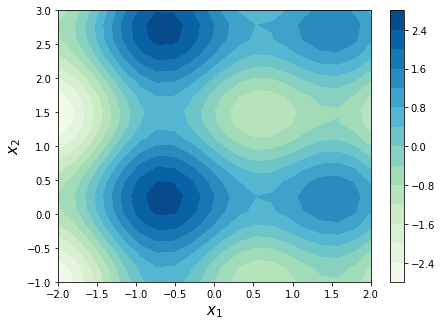

In [16]:
def test2d(X):
    """2D Test Function"""

    # y = (1-X[:, 0])**2 + 100*(X[:, 1]-X[:, 0]**2)**2 
    y = np.cos(X[:, 0] * 0.4 * 3.14) + np.cos(X[:, 0] * 0.8 * 3.14 + 2)  + np.sin(X[:, 1] * 0.8 * 3.14 + 1) 

    return y

# Visualizing the test function
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X = np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1)))
y = test2d(X)

fig, ax = plt.subplots(figsize=(7, 5))
h = ax.contourf(X1, X2, y.reshape(20, -1), levels=15, cmap='GnBu')
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
plt.colorbar(h)


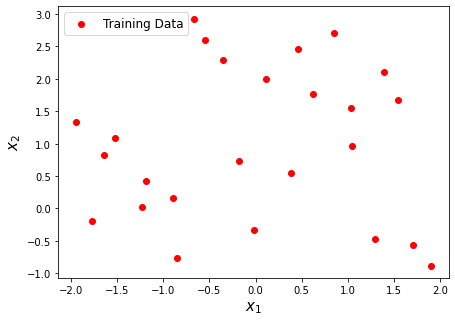

In [17]:
# Training data
sample_num = 25
lb, ub = np.array([-2, -1]), np.array([2, 3])
X_train = (ub-lb)*lhs(2, samples=sample_num) + lb

# Compute labels
y_train = test2d(X_train).reshape(-1, 1)

# Test data
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1)))
y_test = test2d(X_test)

# Vislauzing training samples
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X_train[:, 0], X_train[:, 1], c='r', label='Training Data')
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
ax.legend(loc="upper left", prop={'size': 12})


allocating 3 rows x 2 cols for 5 subplots.
1.0350912774893781
0.8606002812691292
0.5785931950311806
0.458549553489199
0.2560639732236799


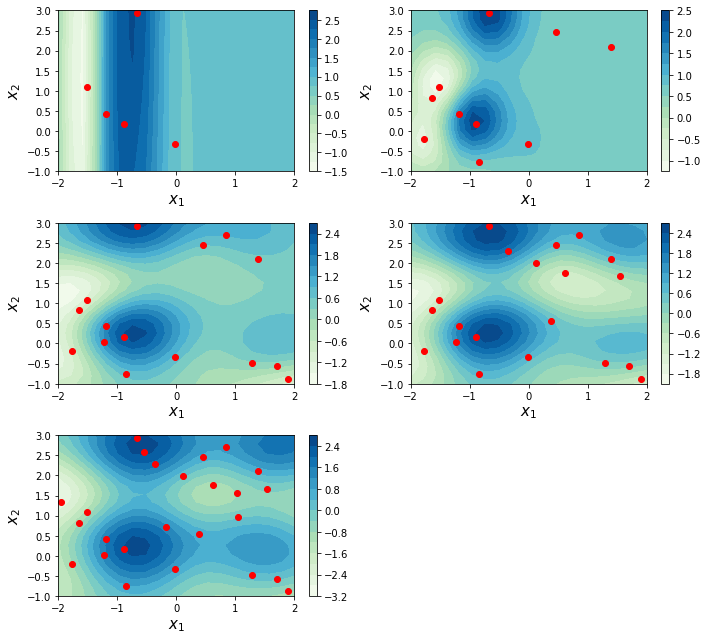

In [18]:
step_points = 5
layout = PlotLayout(plt, len(X_train) // step_points, num_per_row=2, row_width=3, col_width=5)
layout.prepare()

for i in range(1, len(X_train) // step_points + 1):
    # GP model training
    pipe = Pipeline([('scaler', MinMaxScaler()),
                    ('GP', GaussianProcess(n_restarts=10, optimizer='L-BFGS-B'))])
    pipe.fit(X_train[:i * step_points], y_train[:i*step_points])


    # GP model predicting
    y_pred, y_pred_SSqr = pipe.predict(X_test)

    # Post-processing - Contour plot
    ax = layout.subplot(i-1)

    h = ax.contourf(X_test[:, 0].reshape(20, -1),
                    X_test[:, 1].reshape(20, -1),
                    y_pred.reshape(20, -1), levels=15, cmap='GnBu')
    ax.scatter(X_train[:i * step_points, 0], X_train[:i * step_points, 1], color='r')
    ax.set_xlabel(r'$x_1$', fontsize=15)
    ax.set_ylabel(r'$x_2$', fontsize=15)
    fig.colorbar(h, ax=ax)
    plt.tight_layout()
    print(pipe.score(X_test, y_test))
